## Import libraries

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import preprocessing
from itertools import islice
import seaborn as sns
from scipy.stats import binom
from scipy.stats import norm
import statsmodels.stats.api as sms

## Load data

In [2]:
data_frame = pd.read_csv("adsmart.csv")
#sns.set()

In [3]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


#### Drop observations where users didn't respond to the questionaire

In [4]:
drop_mask = data_frame.query('yes==0 and no==0')


In [5]:
data_frame=data_frame.drop(drop_mask.index)

## Count of people that are aware of the smartAd brand for both experiment groups

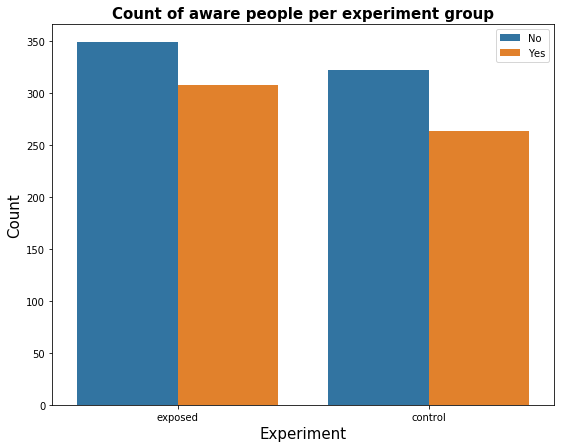

In [19]:
plt.figure(figsize=(9,7))
ax=sns.countplot(x ='experiment', hue='yes', data = data_frame) 

ax.set_xlabel('Experiment', fontsize=15)
ax.set_ylabel('Count' , fontsize=15)
ax.set_title('Count of aware people per experiment group', fontsize=15, fontweight='bold')
plt.legend( ['No', 'Yes'])


### Count plot of browsers. It is dominated by chrome mobile

Text(0.5, 1, 'Count of Browsers used')

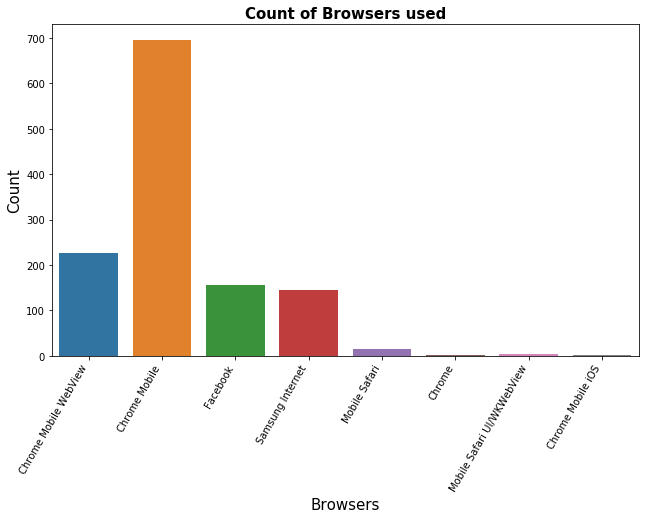

In [20]:
plt.figure(figsize=(9,7))
ax= sns.countplot(x ='browser', data = data_frame) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.tight_layout()
ax.set_xlabel('Browsers', fontsize=15)
ax.set_ylabel('Count' , fontsize=15)
ax.set_title('Count of Browsers used', fontsize=15, fontweight='bold')
    





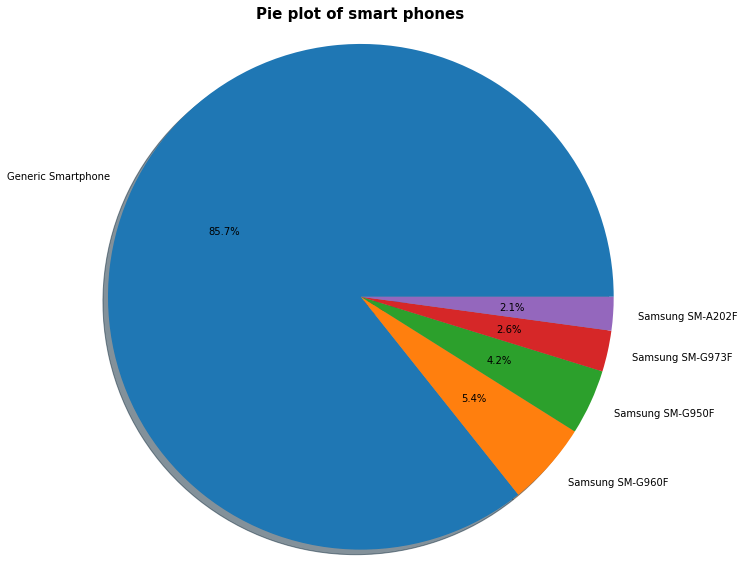

In [22]:
top_5_device= data_frame['device_make'].value_counts().nlargest(5)
fig1, ax1 = plt.subplots(figsize = (10, 10))
ax1.pie(top_5_device.values, labels=top_5_device.index, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')

ax1.set_title('Pie plot of smart phones', fontsize=15, fontweight='bold')
plt.show()

## 85.7% of the recorded data were from an unkonwn device, this makes it difficult for machine learning models to use device_make.

### The following distribution plot shows people use the internet (view the ad) throughout the day. A peak is observed at 16:00

Text(0.5, 1.0, 'Distribution of Hour')

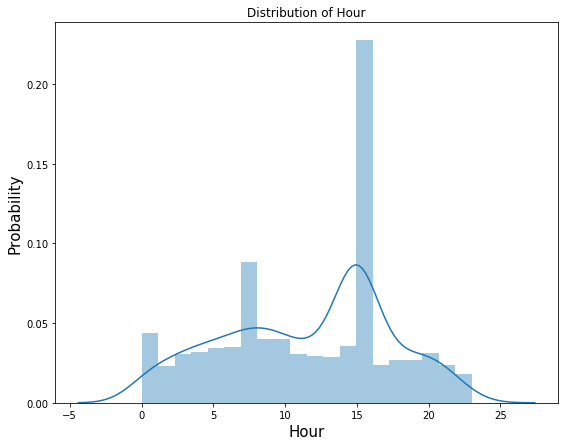

In [21]:
plt.figure(figsize=(9,7))
top_5_device= data_frame['device_make'].value_counts().nlargest(5)
ax=sns.distplot(data_frame['hour'],bins=20) 

ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('Probability' , fontsize=15)
plt.title('Distribution of Hour')

# sns.distplot()

## Split the dataframe to the two experiment groups. The number of total people and aware people are also counted.

In [10]:
exposed_yes = data_frame.query('experiment == "exposed"').yes
exposed_count = len(exposed_yes)
exposed_yes_count = exposed_yes.sum(axis=0)

control_yes = data_frame.query('experiment == "control"').yes
control_count = len(control_yes)
control_yes_count = control_yes.sum(axis=0)
print('Converted Control:',control_yes_count,'    Total Control:',control_count)
print('Converted Exposed:',exposed_yes_count,'    Total Exposed:',exposed_count)

Converted Control: 264     Total Control: 586
Converted Exposed: 308     Total Exposed: 657


## Determine the required sample size.

In [11]:
baseline_rate = control_yes_count / control_count
practical_significance = 0.01 
confidence_level = 0.05 
sensitivity = 0.8 

effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate + practical_significance)
sample_size = sms.NormalIndPower().solve_power(effect_size = effect_size, power = sensitivity, 
                                               alpha = confidence_level, ratio=1)
print("Required sample size: ", round(sample_size), " per group")

Required sample size:  38932  per group


## As shown above, we are short of the required sample size since we have only 586 and 657 in each group

## Determine the probability of having x number of click throughs

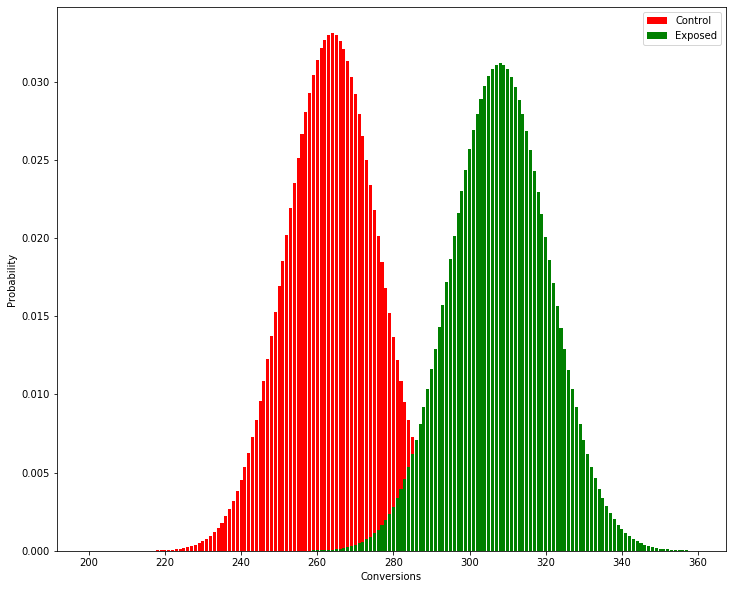

In [12]:
cv_rate_control, cv_rate_exposed = control_yes_count / control_count, exposed_yes_count / exposed_count
range = np.arange(200, 360)
cv_prob_control = binom(control_count, cv_rate_control).pmf(range)
cv_prob_exposed = binom(exposed_count, cv_rate_exposed).pmf(range)
fig, ax = plt.subplots(figsize=(12,10))
plt.bar(range, cv_prob_control, label="Control",color='red')
plt.bar(range, cv_prob_exposed, label="Exposed",color='green')
plt.legend()
plt.xlabel("Conversions"); plt.ylabel("Probability");

### So we can see here that the exposed group has an edge.

## Calculate standard deviations for each experiment group. This will help us change our binomial distribution to normal by using the central limit theorem. We can then calculate z-scores.

In [13]:
std_dev_control = np.sqrt(cv_rate_control * (1 - cv_rate_control) / control_count)
std_dev_exposed = np.sqrt(cv_rate_exposed * (1 - cv_rate_exposed) / exposed_count)

## Calculate conversion rates for each experiment group and plot the probability distribution

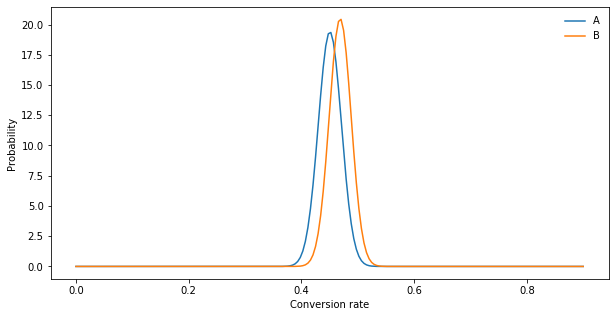

In [14]:
conversion_rate = np.linspace(0, 0.9, 200)
prob_a = norm(cv_rate_control, std_dev_control).pdf(conversion_rate)
prob_b = norm(cv_rate_exposed, std_dev_exposed).pdf(conversion_rate)
plt.figure(figsize=(10,5))
plt.plot(conversion_rate, prob_a, label="A")
plt.plot(conversion_rate, prob_b, label="B")
plt.legend(frameon=False)
plt.xlabel("Conversion rate"); plt.ylabel("Probability");

### So we can see here that the exposed group has an edge.

## Calculate z-score and p-value.

zscore is 0.646, with p-value 0.259


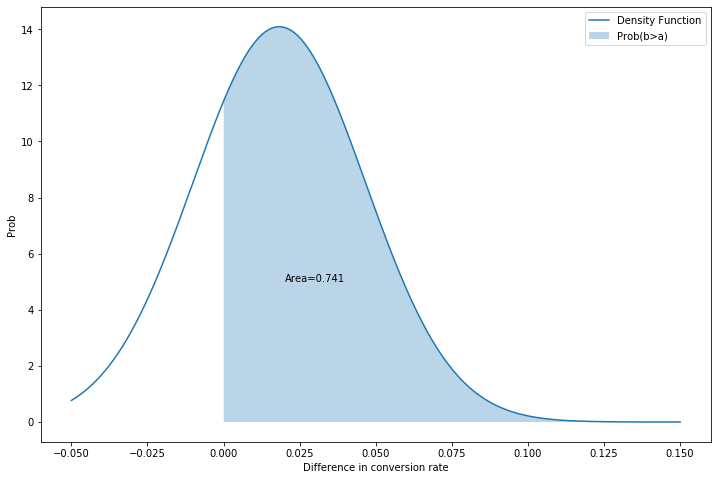

In [15]:
z_score = (cv_rate_exposed - cv_rate_control) / np.sqrt(std_dev_control**2 + std_dev_exposed**2)
p = norm(cv_rate_exposed - cv_rate_control, np.sqrt(std_dev_control**2 + std_dev_exposed**2))

x = np.linspace(-0.05, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.figure(figsize=(12,8))
plt.plot(x, y, label="Density Function")
plt.fill_between(x, 0, y, where=x>0, label="Prob(b>a)", alpha=0.3)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate"); plt.ylabel("Prob");

print(f"zscore is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}")

## Since the p-value(0.259)>0.05, we accept the null hypothesis.

### From our A/B test we can see that even if we saw a rise in conversion rate in the exposed group for this particular experiment, it may be a result of random chance. So we cannot conclude that the experiment group has more awareness.

### But if we analyze the distribution graph and the power value we understand that the sample size taken to condact this testing is very small. There is a very high probability that we will make a type-II error. We need to gather more data to make a sounding conclusion from this testing.